# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\adars\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:25<00:00, 3508.53it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [25]:
final['preprocessed']=preprocessed_reviews

#Creating the feature vector X and target class vector y
X=final['preprocessed']
Y=final['Score']

# let's check the count of each class 
Y.value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [26]:
# Splitting data as train and test set to fit our model and to calculate the performance of the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) # this is random splitting


In [27]:
#importing library
from sklearn import preprocessing

print("Shape of train and test set")
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

#Applying Bag of Words on our data
#Fit_transform the test data and transform  the test data, this is done to prevent data leakage

from sklearn.feature_extraction.text import CountVectorizer

#creating an instance of the count vectoriser to produce bi grams and with maximum fearures being 5000
# countvectorizer takes in the text data and returns the matrix of token counts which is sparse by default

vectorizer = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
vectorizer.fit(X_train) # fit has to happen only on train data
bow_feat=vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#Normalise the data to ensure both are on the same scale
X_train_bown = preprocessing.normalize(X_train_bow)
X_test_bown = preprocessing.normalize(X_test_bow)


Shape of train and test set
(70218,) (70218,)
(17555,) (17555,)


In [28]:
print("After vectorizations")

print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)


After vectorizations
(70218, 5000) (70218,)
(17555, 5000) (17555,)


### Hyperparameter tuning using Grid Search CV 

Results fot CV data
   mean_test_score  std_test_score             params
0         0.948179        0.001744  {'alpha': 0.0001}
1         0.948431        0.001706   {'alpha': 0.001}
2         0.948618        0.001679    {'alpha': 0.01}
3         0.948768        0.001640     {'alpha': 0.1}
4         0.946971        0.001640       {'alpha': 1}
5         0.913289        0.001408      {'alpha': 10}
6         0.726374        0.003304     {'alpha': 100}
7         0.583614        0.001658    {'alpha': 1000}
8         0.494166        0.002481   {'alpha': 10000}


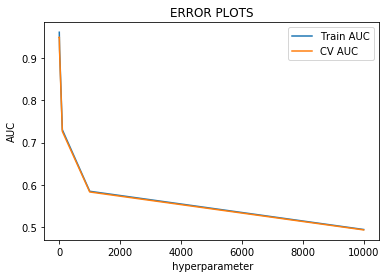

In [29]:
# Code ref : Applied Ai
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#importing libraries
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#creating an instance of the classifier
neigh =MultinomialNB()
parameters = {'alpha':[0.0001,.001,.01,.1,1,10,100,1000,10000]}

#Creating an instance of GCV that performs a 3 fold cross validation by applying Multnomial naive bayes on the data
#with roc_auc as the performance metric and taking a set of parameters 

clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc',n_jobs=-1)  

# fitting with train data
clf.fit(X_train_bown, y_train)

#observing the results- mean auc score, std deviation and the alpha  values
print("Results fot CV data")
print(pd.DataFrame(clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

# lets create a list for the mean auc scores and the standard deviation of these scores(Train  data)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']

# lets create a list for the mean auc scores and the standard deviation of these scores(Test  data)
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plotting the train_auc curve
plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

# plotting the test_auc curve
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel(" hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



In [30]:

# Choosing the Hyperparamter k  based on the max auc score
print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.9487682929879911
{'alpha': 0.1}
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


### Conclusion
Since the cv auc is maximum for alpha = 0.1, train the model with hyperparameter alpha = 0.1

### Training the model with alpha = 0.1

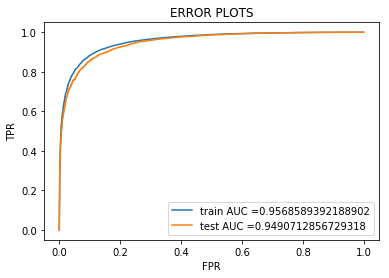

Train confusion matrix
Test confusion matrix


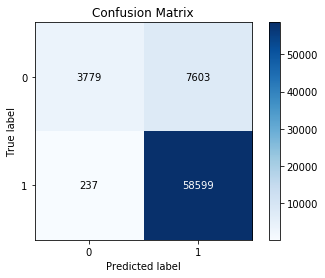

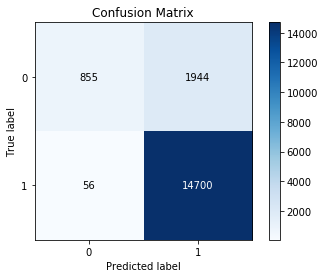

In [31]:
# Code Ref: Applied AI
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import scikitplot as splot

neigh =MultinomialNB(alpha=0.1)
neigh.fit(X_train_bown, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bown)[:,1])

#print( roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1]))
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bown)[:,1])

#plotting the test and train auc curve - TPR v/s FPR
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
splot.metrics.plot_confusion_matrix(y_train, neigh.predict(X_train_bown))

print("Test confusion matrix")
splot.metrics.plot_confusion_matrix(y_test, neigh.predict(X_test_bown))

### Conclusion 
1. By training our model with hyperparameter alpha 0.1 we can observe that test_auc score is .949
2. We can infer that the model clasifies reviews with 94.9% accuracy
3. The Confusion matrix has 1944 false positive points and 56 false negative points which has to be minimised.
4. Both the test and train auc scores are good.
5. We can infer that naive bayes classifier with Bow vectoriser works well on this text classification problem.

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [32]:
# Finding the top 10 features for each class using feature_log_prob attribute from sklearn's implementaion of multinomial naive bayes.
# The feature_log_prob_ attribute return the emperical log probabiltiy for each feature given a class
log_probabilities=neigh.feature_log_prob_

log_p= pd.DataFrame(log_probabilities,columns= bow_feat)

In [33]:
pos=log_p[1:]
pos=pos.T
positive=pos.sort_values(by=1,ascending=False)[0:10]

In [34]:
positive

,1
not,-3.795105
great,-4.521873
like,-4.561786
good,-4.562130
love,-4.860899
one,-4.920076
taste,-4.945026
coffee,-4.980518
product,-4.994209
flavor,-5.023896


These are the top ten features of positive class sorted according their log probabilty values.

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [ ]:
neg = log_p[0:1:]
neg=neg.Tm
negclass = neg.sort_values(by=0,ascending=False)[0:10]


In [47]:
negclass

,0
nose,-4.313549
lightly,-5.117519
processed,-5.208719
taste buds,-5.243239
would also,-5.256385
coffee cup,-5.514748
one bag,-5.536628
nicely,-5.684644
flavor also,-5.698538
good buy,-5.782214


These are the top ten features of negative class sorted according their log probabilty values.

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [48]:

X=final['preprocessed']
Y=final['Score']

# let's check the count of each class 
Y.value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [37]:
# Splitting data as train and test set to fit our model and to calculate the performance of the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) # this is random splitting


In [38]:
#importing library
from sklearn import preprocessing

print("Shape of train and test set")
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

#Applying TF-idf on our data
#Fit_transform the test data and transform  the test data, this is done to prevent data leakage

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
# Fit the train data
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# transform train and test data
X_train_tfidfv = tf_idf_vect.transform(X_train)
X_test_tfidfv=tf_idf_vect.transform(X_test)

#Normalise the data to ensure both are on the same scale
X_train_tfidf = preprocessing.normalize(X_train_tfidfv)
X_test_tfidf = preprocessing.normalize(X_test_tfidfv)

print("After vectorizations")

print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Shape of train and test set
(70218,) (70218,)
(17555,) (17555,)
some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
After vectorizations
(70218, 5000) (70218,)
(17555, 5000) (17555,)


### Hyperparameter tuning using Grid Search CV 

Results fot CV data
   mean_test_score  std_test_score             params
0         0.944245        0.002163  {'alpha': 0.0001}
1         0.944811        0.001960   {'alpha': 0.001}
2         0.945383        0.001792    {'alpha': 0.01}
3         0.946092        0.001696     {'alpha': 0.1}
4         0.946026        0.001681       {'alpha': 1}
5         0.920968        0.003227      {'alpha': 10}
6         0.768816        0.005351     {'alpha': 100}
7         0.665481        0.004277    {'alpha': 1000}
8         0.633546        0.003308   {'alpha': 10000}


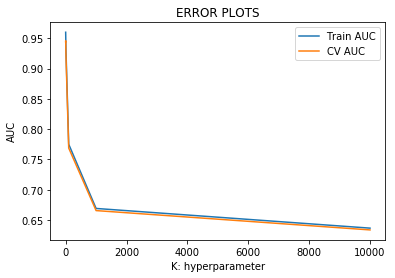

0.9460919386114893
{'alpha': 0.1}
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [39]:
# Code ref : Applied Ai
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#importing libraries
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#creating an instance of the classifier
neigh =MultinomialNB()
parameters = {'alpha':[0.0001,.001,.01,.1,1,10,100,1000,10000]}

#Creating an instance of GCV that performs a 3 fold cross validation by applying Multnomial naive bayes on the data
#with roc_auc as the performance metric and taking a set of parameters 

clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc',n_jobs=-1)

# fitting with train data
clf.fit(X_train_tfidf, y_train)

#observing the results- mean auc score, std deviation and the k values
print("Results fot CV data")
print(pd.DataFrame(clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

# lets create a list for the mean auc scores and the standard deviation of these scores(Train  data)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']

# lets create a list for the mean auc scores and the standard deviation of these scores(Test  data)
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plotting the train_auc curve
plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

# plotting the test_auc curve
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()




# Choosing the Hyperparamter k  based on the max auc score
print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

### Conclusion
Since the cv auc is maximum for alpha = 0.1, train the model with hyperparameter alpha = 0.1

### Training the model with alpha = 0.1

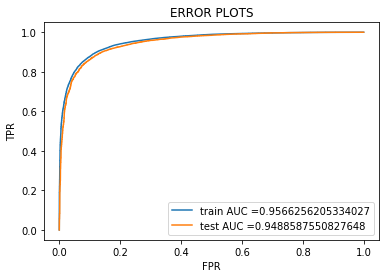

Train confusion matrix
Test confusion matrix


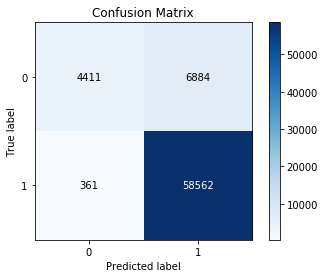

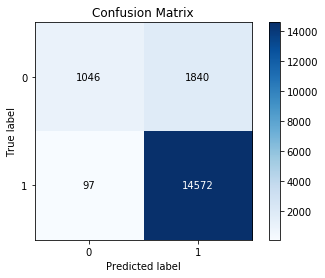

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import scikitplot as splot

neigh = MultinomialNB(alpha=0.1)
neigh.fit(X_train_tfidf, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])

#print( roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1]))
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

#plotting the test and train auc curve - TPR v/s FPR
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
splot.metrics.plot_confusion_matrix(y_train, neigh.predict(X_train_tfidf))

print("Test confusion matrix")
splot.metrics.plot_confusion_matrix(y_test, neigh.predict(X_test_tfidf))

### Conclusion 
1. By training our model with hyperparameter alpha 0.1 we can observe that test_auc score is .948
2. We can infer that the model clasifies reviews with 94.8% accuracy
3. The Confusion matrix has 1840 false positive points and 97 false negative points which has to be minimised.
4. Both the test and train auc scores are good.
5. We can infer that naive bayes classifier with TFidf vectoriser works well on this text classification problem.

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [49]:
# Finding the top 10 features for each class using feature_log_prob attribute from sklearn's implementaion of multinomial naive bayes.
# The feature_log_prob_ attribute return the emperical log probabiltiy for each feature given a class
log_probabilities=neigh.feature_log_prob_

log_p= pd.DataFrame(log_probabilities,columns= bow_feat)
pos=log_p[1:]

pos=pos.T
positive=pos.sort_values(by=1,ascending=False)[0:10]


In [45]:
positive

,1
nose,-4.880628
great coffee,-5.206938
good buy,-5.274068
lightly,-5.327370
coffee cup,-5.376132
love chocolate,-5.437845
tea bag,-5.470499
one bag,-5.554995
taste buds,-5.580466
processed,-5.583979


These are the top ten features of positive class sorted according their log probabilty values.

### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [42]:
neg = log_p[0:1:]
neg=neg.T
negclass = neg.sort_values(by=0,ascending=False)[0:10]


                    0
nose        -4.313549
lightly     -5.117519
processed   -5.208719
taste buds  -5.243239
would also  -5.256385
coffee cup  -5.514748
one bag     -5.536628
nicely      -5.684644
flavor also -5.698538
good buy    -5.782214


In [46]:
negclass

,0
nose,-4.313549
lightly,-5.117519
processed,-5.208719
taste buds,-5.243239
would also,-5.256385
coffee cup,-5.514748
one bag,-5.536628
nicely,-5.684644
flavor also,-5.698538
good buy,-5.782214


These are the top ten features of negative class sorted according their log probabilty values.

# [6] Conclusions

In [51]:
from prettytable import PrettyTable
x = PrettyTable()

In [52]:
x.field_names = ["Vectoriser", "Model", "alpha value", "AUC Score"]

x.add_row(["BOW", "BRUTE", 0.1, 0.949 ])
x.add_row(["TFIDF",  "BRUTE", 0.1, 0.948])

print(x)

+------------+-------+-------------+-----------+
| Vectoriser | Model | alpha value | AUC Score |
+------------+-------+-------------+-----------+
|    BOW     | BRUTE |     0.1     |   0.949   |
|   TFIDF    | BRUTE |     0.1     |   0.948   |
+------------+-------+-------------+-----------+


We can conclude that our naive bayes classifier works well on both BOW and TFIDF vectoriser in this paricular classification task